# Social Network Analysis - Assortativity

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import igraph as ig
import networkx as nx
from scipy.stats import ttest_ind
from mlxtend.evaluate import permutation_test
import seaborn as sns

## 1. Descriptive Gender Analysis

In [2]:
#Load data into dataframe
nodes = pd.read_csv(r'/Users/PJMoon/Data_Science_Projects/SNA/Assortativity/Nodes with attributes.csv')
link = pd.read_csv(r'/Users/PJMoon/Data_Science_Projects/SNA/Assortativity/Links - Intragroup.csv')

#Select columns of interst from node data 
nodes = nodes[['ID','Gender']]

#Out-degree statistics by Gender and Label
link_source = link.rename(columns = {'Source': "ID"})
out_degree = pd.merge(link_source,nodes,how='left',on = 'ID')
by_label_out_degree = out_degree.groupby(['Gender','Label']).ID.count().reset_index()

#In-degree statistics by Gender and Label
link_source2 = link.rename(columns = {"Target":"ID"})
in_degree = pd.merge(link_source2,nodes,how='left',on = 'ID')
by_label_in_degree = in_degree.groupby(['Gender','Label']).ID.count().reset_index()

#Gender to gender in and out degree statistics 
in_degree.rename(columns = {'Gender': 'Gender_in','ID': 'Target2','Source':'Source2','Label':'Label2'},inplace=True)
out_degree.rename(columns = {'Gender': 'Gender_out','ID': 'Source'},inplace=True)
combined = pd.concat([out_degree,in_degree],axis=1)
combined = combined[['Source','Target','Label','Gender_out','Gender_in']]
gender_to_gender = combined.groupby(['Gender_out','Gender_in']).Source.count().reset_index()

In [3]:
#print a number of out-degree by gender and label
by_label_out_degree

,Gender,Label,ID
0,Female,Access,96
1,Female,Career Development,165
2,Female,Decision Making,230
3,Female,Energy,321
4,Female,Innovation,220
5,Female,Personal Support,234
6,Female,Problem Solving,298
7,Female,Strategy,196
8,Female,Trust,274
9,Male,Access,133


In [4]:
#print a number of in-degree by gender and label
by_label_in_degree

,Gender,Label,ID
0,Female,Access,62
1,Female,Career Development,135
2,Female,Decision Making,199
3,Female,Energy,308
4,Female,Innovation,198
5,Female,Personal Support,213
6,Female,Problem Solving,247
7,Female,Strategy,117
8,Female,Trust,237
9,Male,Access,167


In [5]:
#print a number of degrees between genders
gender_to_gender

,Gender_out,Gender_in,Source
0,Female,Female,1010
1,Female,Male,1024
2,Male,Female,706
3,Male,Male,2353


In [6]:
#Gender to gender statistics by label
label = combined['Label'].unique()
for i in range(0,len(label)):
    sector = combined[combined['Label'] == label[i]]
    a = sector.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
    b= print('{0}'.format(label[i]),a)

Energy   Gender_out Gender_in  Source
0     Female    Female     190
1     Female      Male     131
2       Male    Female     118
3       Male      Male     327
Trust   Gender_out Gender_in  Source
0     Female    Female     137
1     Female      Male     137
2       Male    Female     100
3       Male      Male     330
Career Development   Gender_out Gender_in  Source
0     Female    Female      81
1     Female      Male      84
2       Male    Female      54
3       Male      Male     182
Personal Support   Gender_out Gender_in  Source
0     Female    Female     154
1     Female      Male      80
2       Male    Female      59
3       Male      Male     201
Decision Making   Gender_out Gender_in  Source
0     Female    Female     114
1     Female      Male     116
2       Male    Female      85
3       Male      Male     294
Access   Gender_out Gender_in  Source
0     Female    Female      34
1     Female      Male      62
2       Male    Female      28
3       Male      Male     10

## 2. Gender Assortativity 

In [7]:
#Link data preprocessing
a = [i for i in range(0,612)]
nodes['ID2']= a
nodes2 = nodes.rename(columns = {'ID':'Target','ID2':'ID_Target'})
link2 = link[['Source','Target']]
link2 = link2.rename(columns = {'Source' : 'ID'})
link3 = pd.merge(link2,nodes,how='left')
link4 = pd.merge(link3,nodes2,how='left',on='Target')
link_final = link4[['ID2','ID_Target']]
link_final = link_final.rename(columns = {'ID2':'Source','ID_Target':'Target'})
link_final['link'] = list(zip(link_final['Source'],link_final['Target']))
link_final = link_final['link']

#Node data preprocessing
nodes_network = nodes[['ID','Gender']]
nodes_network['Gender2'] = nodes_network['Gender'].map({'Female':1, 'Male':2})

#Creating a network and compute the assortativity
nodes_network['ID'] = [i for i in range(0,612)]
g = ig.Graph()
g.add_vertices([i for i in range(0,612)])
g.add_edges(link_final)
g.vs['Gender'] = nodes_network['Gender2']
print('The assortativity of the network is {0}'.format(g.assortativity_nominal('Gender',directed=True)))

The assortativity of the network is 0.26986616946343467


In [8]:
g.assortativity_degree(directed=True)

0.04431813418505621

In [9]:
layout = g.layout('kamada_kawai')

In [11]:
plot(g,layout = layout)

NameError: name 'plot' is not defined

## 3. Gender Assortativity By Label

In [12]:
#Link data preprocessing
link_label = link[['Source','Target','Label']]
link_label = link_label.rename(columns = {'Source' : 'ID'})
link_label2=pd.merge(link_label,nodes,how='left')
link_label3 = pd.merge(link_label2,nodes2,how='left', on='Target')
link_label_final = link_label3[['ID2','ID_Target','Label']]
link_label_final = link_label_final.rename(columns = {'ID2': 'Source','ID_Target':'Target'})
link_label_final['link'] = list(zip(link_label_final['Source'],link_label_final['Target']))
link_label_final2 = link_label_final[['link','Label']]

#create link data with label
labels = link_label_final2['Label'].unique()
link_data_by_label = []
for label in labels:
    new_label = link_label_final2[link_label_final2['Label'] == label]
    link_data_by_label.append(new_label)
    
    
#create a network and compute the assortativity by label    
node_final = [i for i in range(0,612)]
assortativity=[]
for datum in link_data_by_label:
    g = ig.Graph()
    g.add_vertices(node_final)
    g.add_edges(datum['link'])
    g.vs['Gender'] = nodes_network['Gender2']
    temp = g.assortativity_nominal('Gender',directed = True)
    assortativity.append(temp)
    
assortativity_label = {key: value for key, value in zip(labels,assortativity)}

In [13]:
#print assortativity by label
assortativity_label

{'Energy': 0.32838603700436797,
 'Trust': 0.27198947568214993,
 'Career Development': 0.2650996015936256,
 'Personal Support': 0.4321064231868238,
 'Decision Making': 0.276715679757505,
 'Access': 0.1303797468354431,
 'Innovation': 0.23365849436840877,
 'Problem Solving': 0.24722893422027978,
 'Strategy': 0.0722488805555895}

## Number of out-degree by Gender

In [51]:
out_label = link_label_final[['Source','Label']]
out_label = out_label.rename(columns = {'Source':'ID'})
out_label_gender = pd.merge(out_label,nodes_network,how = 'left',on = 'ID')
out_label_male = out_label_gender[out_label_gender['Gender'] == 'Male']
out_label_female = out_label_gender[out_label_gender['Gender'] == 'Female']
number_degree_male = out_label_male.groupby(['ID']).Gender.count().reset_index()
number_degree_male = number_degree_male.rename(columns = {'Gender': 'Number of out-degree'})
number_degree_female = out_label_female.groupby(['ID']).Gender.count().reset_index()
number_degree_female = number_degree_female.rename(columns = {'Gender':'Number of out-degree'})
number_degree_male2 = number_degree_male['Number of out-degree']
number_degree_female2 = number_degree_female['Number of out-degree']

In [52]:
number_degree_male

,ID,Number of out-degree
0,178,7
1,179,5
2,180,8
3,182,5
4,184,4
...,...,...
250,606,12
251,608,12
252,609,10
253,610,10


In [64]:
number_degree_male['Number of out-degree'].mean()

11.996078431372549

In [65]:
number_degree_female['Number of out-degree'].mean()

12.478527607361963

In [66]:
out_label_male['ID'].nunique()

255

In [67]:
out_label_female['ID'].nunique()

163

In [68]:
not_out = pd.merge(nodes_network,out_label,how='left',on='ID')

In [69]:
not_out[not_out['Label'].isna()]

,ID,Gender,Gender2,Label
0,0,Female,1,NaN
96,10,Female,1,NaN
170,16,Female,1,NaN
321,27,Female,1,NaN
367,33,Female,1,NaN
...,...,...,...,...
5050,588,Male,2,NaN
5060,590,Male,2,NaN
5137,598,Female,1,NaN
5156,600,Male,2,NaN


In [169]:
not_in = pd.merge(nodes_network,in_label,how='left',on='ID')

In [170]:
not_in[not_in['Label'].isna()]

,ID,Gender,Gender2,Label
1,1,Female,1,NaN
53,6,Female,1,NaN
133,10,Female,1,NaN
167,16,Female,1,NaN
207,21,Female,1,NaN
...,...,...,...,...
4566,592,Male,2,NaN
4570,594,Male,2,NaN
4571,595,Male,2,NaN
4580,597,Female,1,NaN


In [171]:
number_degree_male

,ID,Number of out-degree
0,178,7
1,179,5
2,180,8
3,182,5
4,184,4
...,...,...
250,606,12
251,608,12
252,609,10
253,610,10


In [172]:
number_degree_female

,ID,Number of out-degree
0,1,13
1,2,14
2,3,5
3,4,27
4,5,5
...,...,...
158,567,18
159,587,5
160,597,4
161,599,18


Text(0.5, 1.0, 'Number of Out-degree by Gender')

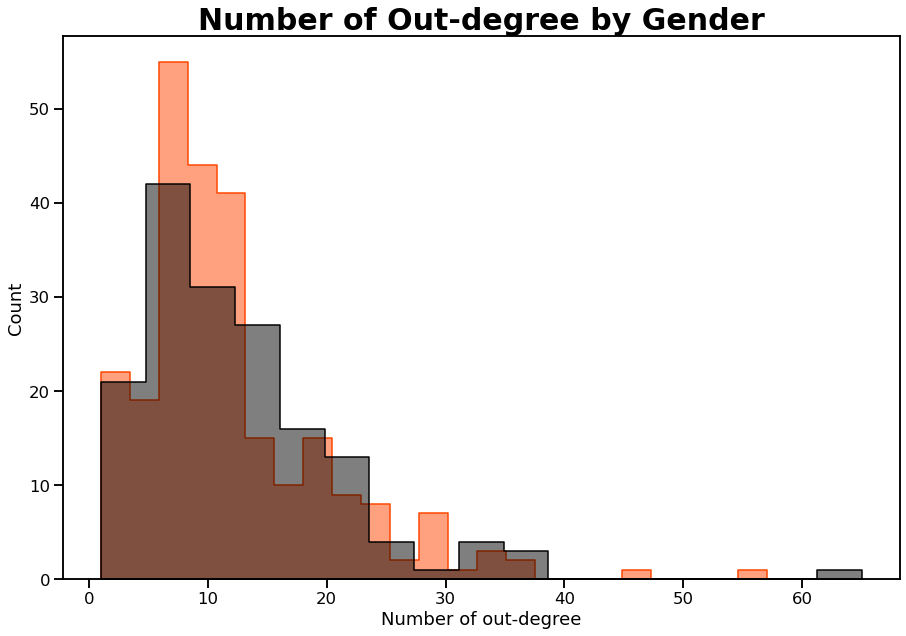

In [173]:
f,ax = plt.subplots(figsize = (15,10))
sns.histplot(number_degree_male2,element = 'step', color='orangered',alpha = .5)
sns.histplot(number_degree_female2, element = 'step',color='black',alpha=.5)

ax.set_title('Number of Out-degree by Gender',fontweight = 'bold',fontsize=30)

## Hypothesis test about the mean out-degree centrality of two groups: male and female

In [160]:
number_degree_male2 = number_degree_male['Number of out-degree']
number_degree_female2 = number_degree_female['Number of out-degree']
tstat,pval_ttest_out = ttest_ind(number_degree_male2,number_degree_female2)
p_val_permu_out = permutation_test(number_degree_male2,number_degree_female2,method='approximate',num_rounds = 10000,seed=0)

In [161]:
pval_ttest_out

0.567235694665136

In [162]:
p_val_permu_out

0.5715428457154285

## Number of in-degree by Gender

In [163]:
in_label = link_label_final[['Target','Label']]
in_label =in_label.rename(columns ={'Target':'ID'})
in_label_gender = pd.merge(in_label,nodes_network,how='left',on='ID')
in_label_male = in_label_gender[in_label_gender['Gender'] =='Male']
in_label_female = in_label_gender[in_label_gender['Gender'] =='Female']
number_in_male = in_label_male.groupby(['ID']).Gender.count().reset_index()
number_in_female = in_label_female.groupby(['ID']).Gender.count().reset_index()

In [164]:
number_in_male

,ID,Gender
0,177,6
1,179,11
2,181,4
3,182,24
4,183,1
...,...,...
278,604,65
279,606,13
280,608,53
281,609,73


In [165]:
number_in_female

,ID,Gender
0,0,1
1,2,27
2,3,7
3,4,12
4,5,5
...,...,...
163,567,2
164,598,17
165,599,1
166,605,5


## Hypothesis test about the mean out-degree centrality of two groups: male and female

In [166]:
number_in_male2 = number_in_male['Gender']
number_in_female2 = number_in_female['Gender']
tstat,pval_ttest_in = ttest_ind(number_in_male2,number_in_female2)
p_val_permu_in = permutation_test(number_in_male2,number_in_female2,method='approximate',num_rounds = 10000,seed=0)

In [167]:
pval_ttest_in

0.3145999977500127

In [168]:
p_val_permu_in

0.3220677932206779